In [1]:
using Random
using Geodesy
using StatsPlots

In [2]:
#import Pkg; Pkg.add("Geodesy")

In [3]:
#import Pkg; Pkg.add("StatsPlots")

In [4]:
#import Pkg
#Pkg.add("Distances")

In [5]:
using Random, Distributions

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β) 
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end

teams = ["SEA", "LAR", "SF", "ARI", "DAL", "NYG", "PHI", "WAS",
         "TB", "CAR", "NO", "ATL", "MIN", "GB", "DET", "CHI",
         "BUF", "NYJ", "MIA", "NE", "HOU", "IND", "TEN", "JAG",
         "KC", "LAC", "DEN", "LV", "PIT", "CLE", "BAL", "CIN"]

stadium_coordinates = Dict(
    "SEA" => (47.595151, -122.331639), "LAR" => (34.014052, -118.287076),
    "ARI" => (33.5276, -112.2626), "SF" => (37.4032, -121.9703),
    "DAL" => (32.7474, -97.0945), "NYG" => (40.8121, -74.0772),
    "PHI" => (39.9008, -75.1675), "WAS" => (38.9078, -76.8645),
    "TB" => (27.9759, -82.5033), "CAR" => (35.2258, -80.8528),
    "NO" => (29.9599, -90.0813), "ATL" => (33.7554, -84.4009),
    "MIN" => (44.9738, -93.2580), "GB" => (44.5013, -88.0622),
    "DET" => (42.3400, -83.0456), "CHI" => (41.8623, -87.6167),
    "BUF" => (42.7739, -78.7870), "NYJ" => (40.8121, -74.0772),
    "MIA" => (25.9579, -80.2389), "NE" => (42.0909, -71.2643),
    "HOU" => (29.6847, -95.4199), "IND" => (39.7601, -86.1638),
    "TEN" => (36.1665, -86.7713), "JAG" => (30.3239, -81.6373),
    "KC" => (39.0489, -94.4839), "LAC" => (34.014052, -118.287076),
    "DEN" => (39.7439, -105.0201), "LV" => (36.0918, -115.1893),
    "PIT" => (40.4467, -80.0158), "CLE" => (41.5061, -81.6995),
    "BAL" => (39.2780, -76.6228), "CIN" => (39.0954, -84.5160)
)

international_games = Dict(
    1 => Dict("location" => "Sao Paulo", "coordinates" => (-23.55052, -46.63331)),
    5 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    6 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    7 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    10 => Dict("location" => "Munich", "coordinates" => (48.1351, 11.5820))
)

bye_weeks = Dict("SEA" => 4, "LAR" => 7, "SF" => 9, "ARI" => 12, "DAL" => 11, "NYG" => 8, "PHI" => 13, "WAS" => 15,
                 "TB" => 6, "CAR" => 10, "NO" => 5, "ATL" => 14, "MIN" => 3, "GB" => 16, "DET" => 2, "CHI" => 18,
                 "BUF" => 1, "NYJ" => 17, "MIA" => 12, "NE" => 8, "HOU" => 11, "IND" => 9, "TEN" => 14, "JAG" => 4,
                 "KC" => 3, "LAC" => 13, "DEN" => 10, "LV" => 16, "PIT" => 7, "CLE" => 15, "BAL" => 5, "CIN" => 2)

function haversine(lat1, lon1, lat2, lon2)
    r = 6371  
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    a = sin(dlat / 2)^2 + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * sin(dlon / 2)^2
    c = 2 * atan(sqrt(a), sqrt(1 - a))
    return r * c
end

function calculate_distance(home_team, opponent, game_location, stadium_coordinates, international_games)
    if game_location == "Home"
        home_coords = stadium_coordinates[home_team]
        away_coords = stadium_coordinates[opponent]
        return haversine(home_coords[1], home_coords[2], away_coords[1], away_coords[2])
    else
        coords = international_games[game_location]["coordinates"]
        home_coords = stadium_coordinates[home_team]
        return haversine(home_coords[1], home_coords[2], coords[1], coords[2])
    end
end

schedule = Dict(week => Dict() for week in 1:18)
total_kilometers = 0.0

μ = 0  
β = 1  
threshold = 10.0  #bardzo rzadkie zdarzenie

teams_played = Dict(week => Set{String}() for week in 1:18)

for (week, details) in international_games
    city = details["location"]
    coords = details["coordinates"]
    host_team = Random.shuffle(teams)[1]
    available_opponents = setdiff(teams, [host_team])
    opponent = Random.shuffle(available_opponents)[1]
    if should_cancel_game_gumbel(μ, β, threshold)
        println("  [!] Game in week $week canceled in $city (reason: extreme event)")
        continue
    end
    distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
    total_kilometers += distance
    schedule[week][host_team] = (opponent, city, distance)
    push!(teams_played[week], host_team, opponent)
end

for week in 1:18
    for team in teams
        if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
            continue
        end
        if should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Game in week $week involving $team canceled (reason: extreme event)")
            continue
        end
        available_opponents = setdiff(teams, union([team], teams_played[week]))
        if !isempty(available_opponents)
            opponent = Random.shuffle(available_opponents)[1]
            distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
            total_kilometers += distance
            schedule[week][team] = (opponent, "Home", distance)
            push!(teams_played[week], team, opponent)
        end
    end
end

for week in 1:18
    println("Week $week:")
    for (team, (opponent, city, distance)) in schedule[week]
        println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
    end
end

println("\nTotal kilometers traveled by all teams: $(round(total_kilometers, digits=2)) km")

Week 1:
  DET vs CIN in Home, Distance: 381.45 km
  HOU vs PHI in Sao Paulo, Distance: 7886.19 km
  MIA vs BAL in Home, Distance: 1518.97 km
  NE vs TEN in Home, Distance: 1487.95 km
  LAR vs CHI in Home, Distance: 2810.29 km
  SF vs CLE in Home, Distance: 3455.97 km
  DAL vs CAR in Home, Distance: 1520.8 km
  NYG vs WAS in Home, Distance: 318.46 km
  ARI vs KC in Home, Distance: 1704.05 km
  NO vs JAG in Home, Distance: 812.79 km
  MIN vs DEN in Home, Distance: 1126.26 km
  TB vs PIT in Home, Distance: 1405.25 km
  SEA vs LAC in Home, Distance: 1547.47 km
  GB vs IND in Home, Distance: 549.91 km
  ATL vs LV in Home, Distance: 2807.29 km
  NYJ vs BUF in Home, Distance: 447.16 km
Week 2:
  BUF vs TEN in Home, Distance: 1003.8 km
  LAR vs PHI in Home, Distance: 3848.99 km
  SF vs TB in Home, Distance: 3809.06 km
  DAL vs NE in Home, Distance: 2493.63 km
  NYG vs WAS in Home, Distance: 318.46 km
  ARI vs CLE in Home, Distance: 2820.59 km
  NO vs BAL in Home, Distance: 1606.2 km
  MIN vs C

In [6]:
using Statistics
using Plots
using DataFrames


function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)  
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end


function simulate_schedule!(international_assignments, μ, β, threshold, team_distances)
    schedule = Dict(week => Dict() for week in 1:18)
    weekly_distances = zeros(Float64, 18)
    total_kilometers = 0.0

   
    for (week, details) in international_games
        city = details["location"]
        coords = details["coordinates"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = Random.shuffle(available_opponents)[1]

        if should_cancel_game_gumbel(μ, β, threshold)
            println("[!] Mecz w tygodniu $week odwołany w $city z powodu ekstremalnego zdarzenia")
            continue  
        end

        distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        weekly_distances[week] += distance
        schedule[week][host_team] = (opponent, city, distance)
        international_assignments[host_team] += 1  
        team_distances[host_team] += distance  
    end

   
    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team)
                continue
            end

            if should_cancel_game_gumbel(μ, β, threshold)
                println("[!] Mecz w tygodniu $week z udziałem $team odwołany z powodu ekstremalnego zdarzenia")
                continue
            end

            available_opponents = setdiff(teams, union([team], keys(schedule[week])))
            if !isempty(available_opponents)
                opponent = Random.shuffle(available_opponents)[1]
                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                weekly_distances[week] += distance
                schedule[week][team] = (opponent, "Home", distance)
                team_distances[team] += distance  
            end
        end
    end

    return total_kilometers, weekly_distances
end

μ, β, threshold = 0, 0.05, 4.0

num_simulations = 100
results = Float64[]
weekly_totals = zeros(Float64, 18)
team_totals = Dict(team => 0.0 for team in teams)
international_assignments = Dict(team => 0 for team in teams)
weekly_distances_all_simulations = [zeros(Float64, 18) for _ in 1:num_simulations]

for sim in 1:num_simulations
    total_kilometers, weekly_distances = simulate_schedule!(international_assignments, μ, β, threshold, team_totals)
    push!(results, total_kilometers)
    weekly_totals .+= weekly_distances
    weekly_distances_all_simulations[sim] .= weekly_distances
end

In [13]:
median_weekly_distances = Float64[]
p5_weekly_distances = Float64[]
p95_weekly_distances = Float64[]

for week in 1:18
    distances_for_week = [sim[week] for sim in weekly_distances_all_simulations]
    push!(median_weekly_distances, median(distances_for_week))
    push!(p5_weekly_distances, quantile(distances_for_week, 0.05))
    push!(p95_weekly_distances, quantile(distances_for_week, 0.95))
end

In [14]:
average_weekly_distances = weekly_totals ./ num_simulations

average_team_distances = Dict(team => team_totals[team] / num_simulations for team in teams)

week_data = DataFrame(Week=1:18, AvgDistance=average_weekly_distances)

println("\nTabela średnich odległości pokonywanych w każdym tygodniu:")
println(week_data)

println("\nTabela średnich odległości pokonywanych przez zespół w sezonie:")
println(average_team_distances)


Tabela średnich odległości pokonywanych w każdym tygodniu:
18×2 DataFrame
 Row │ Week   AvgDistance 
     │ Int64  Float64     
─────┼────────────────────
   1 │     1      55508.1
   2 │     2      48477.2
   3 │     3      48663.1
   4 │     4      52195.0
   5 │     5      53848.0
   6 │     6      56513.3
   7 │     7      55953.0
   8 │     8      48261.4
   9 │     9      50882.8
  10 │    10      54354.6
  11 │    11      49708.1
  12 │    12      51475.0
  13 │    13      49061.4
  14 │    14      47847.6
  15 │    15      48245.7
  16 │    16      48902.8
  17 │    17      49448.4
  18 │    18      48219.6

Tabela średnich odległości pokonywanych przez zespół w sezonie:
Dict("DET" => 20505.729142715987, "BUF" => 23383.442184798318, "CIN" => 21225.634619154287, "HOU" => 28548.73883653646, "PIT" => 11874.637511019007, "CLE" => 15721.648593929038, "MIA" => 33965.26918263875, "NE" => 33838.34838040965, "IND" => 20531.85830687922, "TEN" => 22692.333416148158, "LAR" => 48262.652752

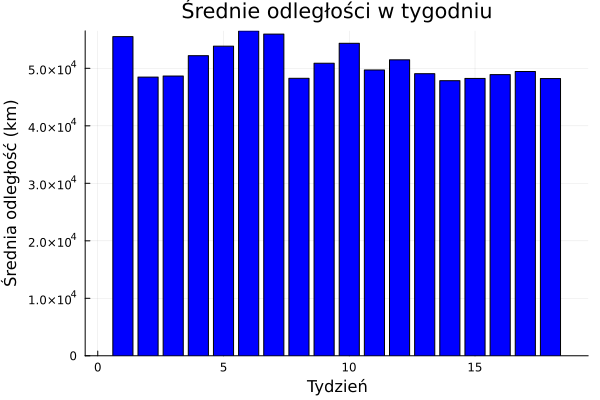

In [15]:
bar(
    week_data.Week,
    week_data.AvgDistance,
    xlabel="Tydzień",
    ylabel="Średnia odległość (km)",
    title="Średnie odległości w tygodniu",
    label="Weekly Avg Dist",
    color=:blue,
    legend=false
)

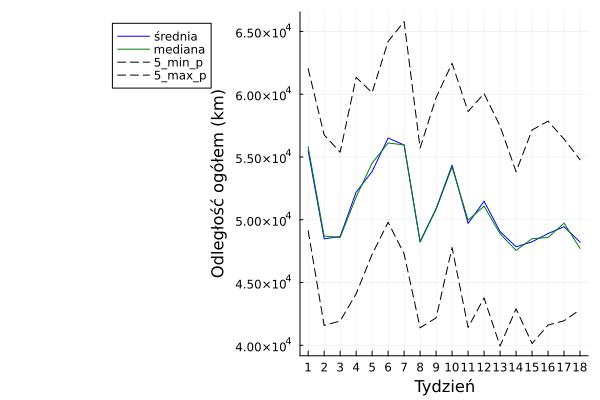

In [16]:
p = plot(titlefontsize=10, xlabel="Tydzień", ylabel="Odległość ogółem (km)", left_margin=6Plots.mm, legend=:outertopleft)

    plot!(p, 1:18, average_weekly_distances, color=:blue, linestyle=:solid, label="średnia")
    plot!(p, 1:18, median_weekly_distances, color=:green, linestyle=:solid, label="mediana")
    plot!(p, 1:18, p5_weekly_distances, color=:black, linestyle=:dash, label="5_min_p")
    plot!(p, 1:18, p95_weekly_distances, color=:black, linestyle=:dash, label="5_max_p")
    xticks!(1:18)

In [19]:
team_data = DataFrame(Team=collect(keys(average_team_distances)), AvgDistance=collect(values(average_team_distances)))

sort!(team_data, :AvgDistance, rev=true)

println("\nTabela średnich odległości pokonywanych przez drużyny:")
println(team_data)


Tabela średnich odległości pokonywanych przez drużyny:
32×2 DataFrame
 Row │ Team    AvgDistance 
     │ String  Float64     
─────┼─────────────────────
   1 │ SF          52927.6
   2 │ SEA         51859.1
   3 │ LV          49340.1
   4 │ LAR         48262.7
   5 │ LAC         44550.9
   6 │ ARI         43345.2
   7 │ MIA         33965.3
   8 │ NE          33838.3
   9 │ DEN         32205.2
  10 │ JAG         31444.5
  11 │ HOU         28548.7
  12 │ NYJ         27694.9
  13 │ DAL         27442.5
  14 │ TB          26725.1
  15 │ NO          25843.2
  16 │ KC          24769.5
  17 │ MIN         23771.8
  18 │ BUF         23383.4
  19 │ NYG         22878.1
  20 │ TEN         22692.3
  21 │ PHI         22460.9
  22 │ ATL         22178.0
  23 │ GB          22061.5
  24 │ WAS         21842.9
  25 │ CHI         21788.4
  26 │ CIN         21225.6
  27 │ CAR         20984.2
  28 │ BAL         20901.2
  29 │ IND         20531.9
  30 │ DET         20505.7
  31 │ CLE         15721.6
  32 │ P

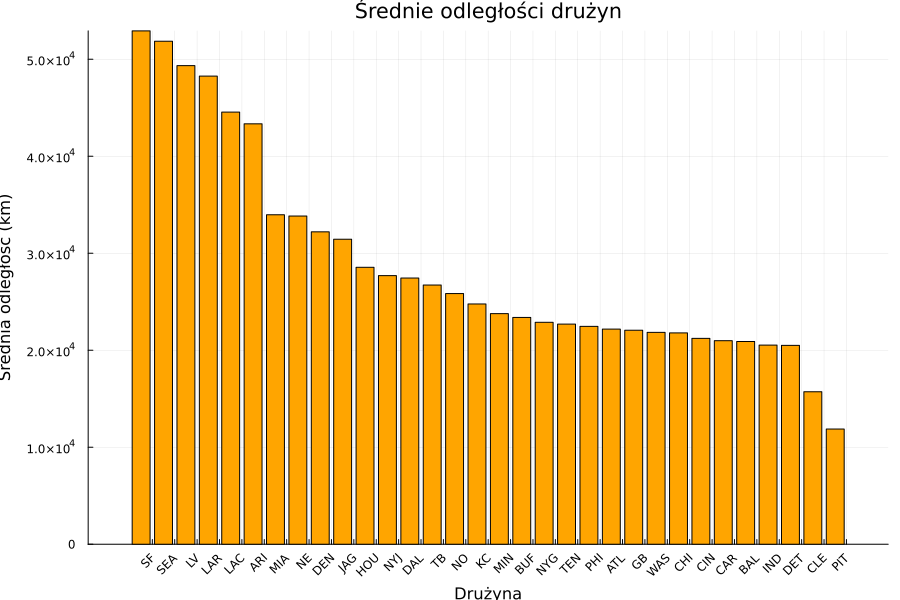

In [20]:
bar(
    team_data.Team,
    team_data.AvgDistance,
    xlabel="Drużyna",
    ylabel="Średnia odległość (km)",
    title="Średnie odległości drużyn",
    label="Team Avg Distances",
    color=:orange,
    legend=false,
    xticks=(1:length(team_data.Team), team_data.Team),  
    size=(900, 600),  
    xrotation=45
)


Average Total Kilometers: 917565.06
Standard Deviation of Total Kilometers: 19859.05


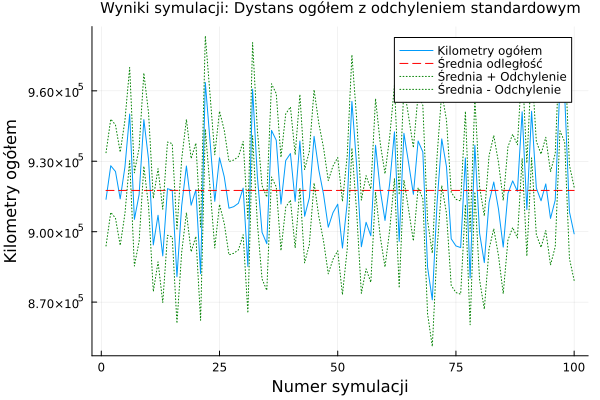

In [21]:
avg_distance = mean(results)
std_dev_distance = std(results)

println("\nAverage Total Kilometers: ", round(avg_distance, digits=2))
println("Standard Deviation of Total Kilometers: ", round(std_dev_distance, digits=2))

simulation_runs = 1:num_simulations
plot(simulation_runs, results, label="Kilometry ogółem", xlabel="Numer symulacji", ylabel="Kilometry ogółem", titlefontsize=10,
     title="Wyniki symulacji: Dystans ogółem z odchyleniem standardowym", lw=1, legend=:topright)
plot!(simulation_runs, fill(avg_distance, num_simulations), label="Średnia odległość", linestyle=:dash, color=:red)
plot!(simulation_runs, results .+ std_dev_distance, label="Średnia + Odchylenie", linestyle=:dot, color=:green)
plot!(simulation_runs, results .- std_dev_distance, label="Średnia - Odchylenie", linestyle=:dot, color=:green)

In [19]:
using Statistics, Random, Distributions

divisions = Dict(
    "NFC_West" => ["SEA", "LAR", "SF", "ARI"],
    "NFC_East" => ["DAL", "NYG", "PHI", "WAS"],
    "NFC_South" => ["TB", "CAR", "NO", "ATL"],
    "NFC_North" => ["MIN", "GB", "DET", "CHI"],
    "AFC_East" => ["BUF", "NYJ", "MIA", "NE"],
    "AFC_South" => ["HOU", "IND", "TEN", "JAG"],
    "AFC_West" => ["KC", "LAC", "DEN", "LV"],
    "AFC_North" => ["PIT", "CLE", "BAL", "CIN"]
)

function is_division_game(team1, team2, divisions)
    for (_, teams) in divisions
        if team1 in teams && team2 in teams
            return true
        end
    end
    return false
end

function find_closest_opponent_with_limit(home_team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)
    distances = Dict(opponent => haversine(stadium_coordinates[home_team][1], stadium_coordinates[home_team][2],
                                           stadium_coordinates[opponent][1], stadium_coordinates[opponent][2])
                     for opponent in available_opponents)

   
    sorted_opponents = sort(collect(distances), by=x -> x[2])

    for (opponent, _) in sorted_opponents
        if is_division_game(home_team, opponent, divisions)
            if division_game_count[home_team] >= max_derby_games || division_game_count[opponent] >= max_derby_games
                continue #losowany jest inny przeciwnik
            end
        end
        return opponent  
    end
    return nothing 
end

function generate_min_distance_schedule(μ, β, threshold, max_derby_games)
    schedule = Dict(week => Dict() for week in 1:18)
    total_kilometers = 0.0
    teams_played = Dict(week => Set{String}() for week in 1:18)
    division_game_count = Dict(team => 0 for team in teams) 

    
    for (week, details) in international_games
        city = details["location"]
        coords = details["coordinates"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = find_closest_opponent_with_limit(host_team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)

        if opponent === nothing || should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Game in week $week canceled in $city (reason: extreme event or no valid opponent)")
            continue
        end

        distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        schedule[week][host_team] = (opponent, city, distance)
        push!(teams_played[week], host_team, opponent)

        if is_division_game(host_team, opponent, divisions)
            division_game_count[host_team] += 1
            division_game_count[opponent] += 1
        end
    end

   
    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
                continue
            end
            if should_cancel_game_gumbel(μ, β, threshold)
                println("  [!] Game in week $week involving $team canceled (reason: extreme event)")
                continue
            end

            available_opponents = setdiff(teams, union([team], teams_played[week]))
            if !isempty(available_opponents)
                opponent = find_closest_opponent_with_limit(team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)
                if opponent === nothing
                    println("  [!] No valid opponent for $team in week $week")
                    continue
                end

                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                schedule[week][team] = (opponent, "Home", distance)
                push!(teams_played[week], team, opponent)

                if is_division_game(team, opponent, divisions)
                    division_game_count[team] += 1
                    division_game_count[opponent] += 1
                end
            end
        end
    end

    return schedule, total_kilometers
end


μ = 0  
β = 1  
threshold = 4.0  
max_derby_games = 2  

schedule, total_kilometers = generate_min_distance_schedule(μ, β, threshold, max_derby_games)

for week in 1:18
    println("Week $week:")
    for (team, (opponent, city, distance)) in schedule[week]
        println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
    end
end

println("\nTotal kilometers traveled by all teams: $(round(total_kilometers, digits=2)) km")


  [!] Game in week 2 involving DAL canceled (reason: extreme event)
  [!] No valid opponent for BUF in week 8
  [!] No valid opponent for MIA in week 10
  [!] No valid opponent for NE in week 10
  [!] No valid opponent for MIA in week 11
  [!] No valid opponent for NE in week 11
  [!] No valid opponent for MIA in week 13
  [!] No valid opponent for NE in week 13
  [!] Game in week 14 involving CHI canceled (reason: extreme event)
  [!] No valid opponent for MIA in week 15
  [!] No valid opponent for NE in week 15
  [!] No valid opponent for MIA in week 16
  [!] No valid opponent for NE in week 16
  [!] No valid opponent for MIA in week 17
  [!] No valid opponent for NE in week 17
  [!] Game in week 18 involving GB canceled (reason: extreme event)
Week 1:
  DET vs CLE in Home, Distance: 144.91 km
  MIA vs CIN in Home, Distance: 1514.33 km
  NE vs BUF in Home, Distance: 621.83 km
  LAR vs LAC in Sao Paulo, Distance: 9907.76 km
  DAL vs HOU in Home, Distance: 375.93 km
  PHI vs BAL in Hom

In [23]:
using Statistics, Plots, Random, Distributions

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)
    extreme_value = rand(gumbel_dist)
    return extreme_value > threshold
end

divisions = Dict(
    "NFC West" => ["SEA", "LAR", "SF", "ARI"],
    "NFC East" => ["DAL", "NYG", "PHI", "WAS"],
    "NFC North" => ["MIN", "GB", "DET", "CHI"],
    "NFC South" => ["TB", "CAR", "NO", "ATL"],
    "AFC West" => ["KC", "LAC", "DEN", "LV"],
    "AFC East" => ["BUF", "NYJ", "MIA", "NE"],
    "AFC North" => ["PIT", "CLE", "BAL", "CIN"],
    "AFC South" => ["HOU", "IND", "TEN", "JAG"]
)

function same_division(team1, team2, divisions)
    for (_, teams) in divisions
        if team1 in teams && team2 in teams
            return true
        end
    end
    return false
end

function sensitivity_analysis(max_home_streak::Int, max_division_matches::Int)
    println("\n--- Analiza Wrażliwości ---")
    println("Maksymalna liczba meczów u siebie z rzędu: $max_home_streak")
    println("Maksymalna liczba meczów dywizji z rzędu: $max_division_matches")

    home_streak = Dict(team => 0 for team in teams)
    division_streak = Dict(team => 0 for team in teams)
    teams_played = Dict(week => Set() for week in 1:18)
    schedule = Dict(week => Dict() for week in 1:18)
    total_kilometers = 0.0
    weekly_distances = zeros(Float64, 18)
    team_distances = Dict(team => 0.0 for team in teams)

    μ, β, threshold = 0, 0.05, 4.0 

    for (week, details) in international_games
        city = details["location"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = Random.shuffle(available_opponents)[1]
        if should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Mecz w tygodniu $week odwołany w $city (przyczyna: ekstremalne zdarzenie)")
            continue
        end
        distance = haversine(details["coordinates"][1], details["coordinates"][2],
                              stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        schedule[week][host_team] = (opponent, city, distance)
        teams_played[week] = union(teams_played[week], [host_team, opponent])
        weekly_distances[week] += distance
        team_distances[host_team] += distance
    end

    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
                continue
            end
            if should_cancel_game_gumbel(μ, β, threshold)
                println("  [!] Mecz w tygodniu $week z udziałem $team odwołany (przyczyna: ekstremalne zdarzenie)")
                continue
            end
            available_opponents = setdiff(teams, union([team], keys(schedule[week]), collect(teams_played[week])))

           
            available_opponents = filter(o -> !(same_division(team, o, divisions) && division_streak[team] >= max_division_matches), available_opponents)

            if !isempty(available_opponents)
                opponent = Random.shuffle(available_opponents)[1]
                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                schedule[week][team] = (opponent, "Home", distance)
                teams_played[week] = union(teams_played[week], [team, opponent])
                weekly_distances[week] += distance
                team_distances[team] += distance

            
                if same_division(team, opponent, divisions)
                    division_streak[team] += 1
                else
                    division_streak[team] = 0
                end
            end
        end
    end

   
    for week in 1:18
        println("Week $week:")
        for (team, (opponent, city, distance)) in schedule[week]
            println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
        end
    end

    println("\nŁączna liczba kilometrów przejechanych przez wszystkie drużyny: $(round(total_kilometers, digits=2)) km")

    
    average_weekly_distances = weekly_distances ./ length(teams)
    println("\nŚrednie tygodniowe odległości:")
    week_data = DataFrame(Week=1:18, AvgDistance=average_weekly_distances)
    println(week_data)

    
    average_team_distances = Dict(k => v / 18 for (k, v) in team_distances)
    println("\nŚrednie odległości pokonywane przez drużyny:")
    team_data = DataFrame(Team=collect(keys(average_team_distances)), AvgDistance=collect(values(average_team_distances)))
    sort!(team_data, :AvgDistance, rev=true)
    println(team_data)

    
    bar(
        week_data.Week,
        week_data.AvgDistance,
        xlabel="Week",
        ylabel="Average Distance (km)",
        title="Average Weekly Distances",
        color=:blue,
        legend=false
    )

   
    bar(
        team_data.Team,
        team_data.AvgDistance,
        xlabel="Team",
        ylabel="Average Distance (km)",
        title="Average Team Distances",
        color=:orange,
        legend=false,
        xticks=(1:length(team_data.Team), team_data.Team),
        size=(900, 600),
        xrotation=45
    )
end


sensitivity_analysis (generic function with 1 method)


Analiza wrażliwości: Limit 4 mecze u siebie, maksymalnie 2 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 4
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  NE vs HOU in Home, Distance: 2562.48 km
  LAR vs KC in Home, Distance: 2192.18 km
  SF vs PIT in Home, Distance: 3610.96 km
  DAL vs IND in Home, Distance: 1250.82 km
  PHI vs JAG in Home, Distance: 1215.82 km
  NYG vs TEN in Home, Distance: 1218.04 km
  ARI vs CLE in Home, Distance: 2820.59 km
  MIN vs LV in Home, Distance: 2090.67 km
  TB vs DEN in Sao Paulo, Distance: 6900.27 km
  SEA vs NO in Home, Distance: 3375.85 km
  GB vs CHI in Home, Distance: 295.66 km
  CAR vs DET in Home, Distance: 813.49 km
  ATL vs BUF in Home, Distance: 1115.51 km
  LAC vs CIN in Home, Distance: 3050.81 km
  WAS vs MIA in Home, Distance: 1474.05 km
  NYJ vs BAL in Home, Distance: 275.76 km
Week 2:
  BUF vs KC in Home, Distance: 1380.14 km
  IND vs TEN in Home, Distance: 403.12 km
  LAR vs NYJ in Home, D

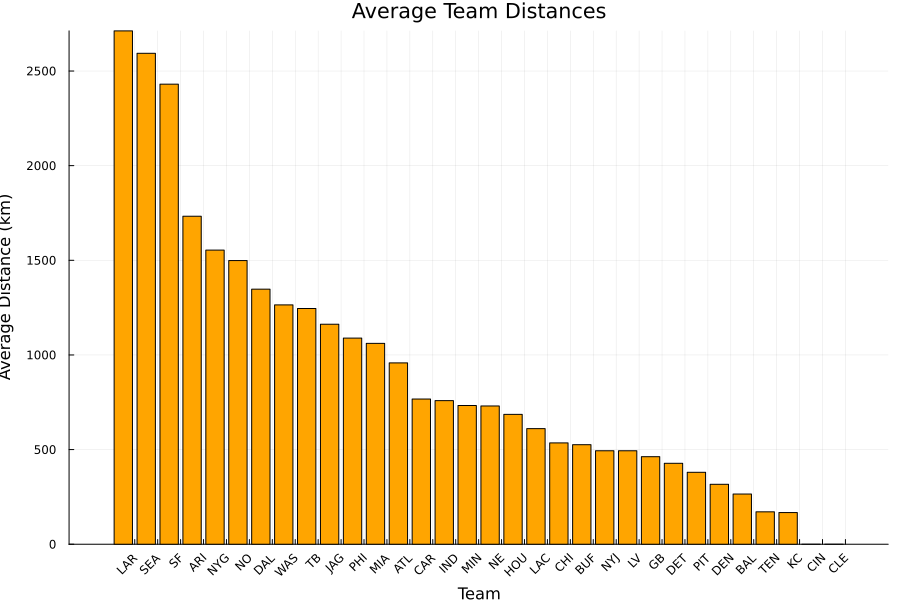

In [24]:
println("\nAnaliza wrażliwości: Limit 4 mecze u siebie, maksymalnie 2 mecze z dywizji")
sensitivity_analysis(4, 2)


Analiza wrażliwości: Limit 3 mecze u siebie, maksymalnie 4 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 3
Maksymalna liczba meczów dywizji z rzędu: 4
Week 1:
  DET vs DEN in Home, Distance: 1860.04 km
  PIT vs CLE in Home, Distance: 183.99 km
  MIA vs PHI in Sao Paulo, Distance: 6586.16 km
  TEN vs CIN in Home, Distance: 381.43 km
  LAR vs NO in Home, Distance: 2689.32 km
  SF vs GB in Home, Distance: 2931.7 km
  DAL vs IND in Home, Distance: 1250.82 km
  ARI vs NYG in Home, Distance: 3450.12 km
  MIN vs HOU in Home, Distance: 1710.61 km
  TB vs NYJ in Home, Distance: 1621.3 km
  SEA vs JAG in Home, Distance: 3946.96 km
  CHI vs NE in Home, Distance: 1349.94 km
  CAR vs BUF in Home, Distance: 858.0 km
  KC vs LAC in Home, Distance: 2192.18 km
  LV vs BAL in Home, Distance: 3386.54 km
  WAS vs ATL in Home, Distance: 884.85 km
Week 2:
  BUF vs JAG in Home, Distance: 1407.35 km
  HOU vs KC in Home, Distance: 1044.77 km
  MIA vs DET in Home, Dist

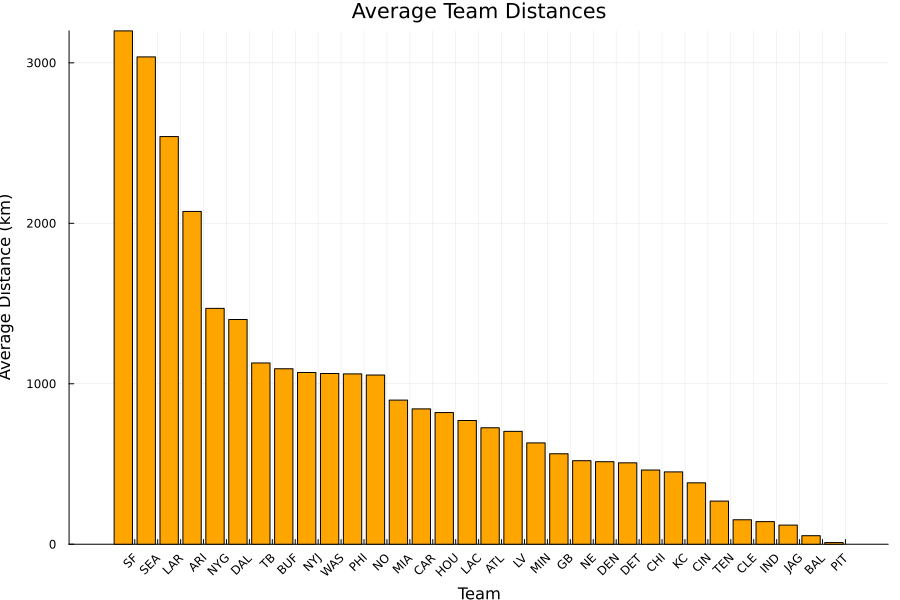

In [25]:
println("\nAnaliza wrażliwości: Limit 3 mecze u siebie, maksymalnie 4 mecze z dywizji")
sensitivity_analysis(3, 4)


Analiza wrażliwości: Limit 4 mecze u siebie, maksymalnie 3 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 4
Maksymalna liczba meczów dywizji z rzędu: 3
Week 1:
  MIA vs DET in Sao Paulo, Distance: 6586.16 km
  NE vs CIN in Home, Distance: 1166.04 km
  LAR vs KC in Home, Distance: 2192.18 km
  SF vs ARI in Home, Distance: 978.41 km
  DAL vs GB in Home, Distance: 1522.19 km
  PHI vs BAL in Home, Distance: 142.64 km
  NYG vs CAR in Home, Distance: 858.6 km
  NO vs PIT in Home, Distance: 1479.72 km
  MIN vs BUF in Home, Distance: 1183.75 km
  TB vs TEN in Home, Distance: 995.28 km
  SEA vs IND in Home, Distance: 3005.67 km
  CHI vs CLE in Home, Distance: 492.88 km
  LAC vs DEN in Home, Distance: 1339.05 km
  WAS vs ATL in Home, Distance: 884.85 km
  NYJ vs HOU in Home, Distance: 2289.75 km
  JAG vs LV in Home, Distance: 3170.35 km
Week 2:
  HOU vs CLE in Home, Distance: 1802.91 km
  MIA vs BAL in Home, Distance: 1518.97 km
  IND vs JAG in Home, Dis

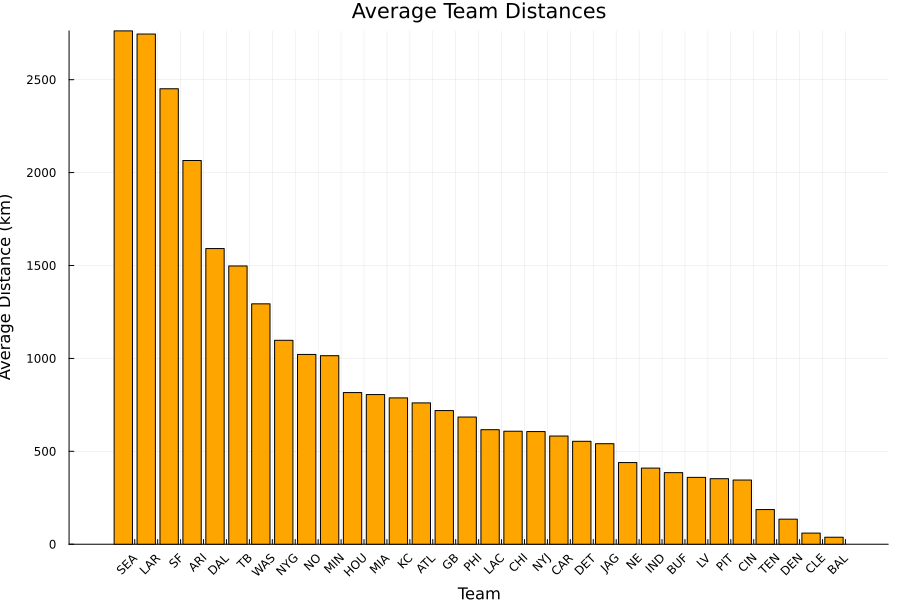

In [26]:
println("\nAnaliza wrażliwości: Limit 4 mecze u siebie, maksymalnie 3 mecze z dywizji")
sensitivity_analysis(4, 3)


Analiza wrażliwości: Limit 2 mecze u siebie, maksymalnie 3 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 2
Maksymalna liczba meczów dywizji z rzędu: 3
Week 1:
  HOU vs IND in Home, Distance: 1402.05 km
  MIA vs TB in Sao Paulo, Distance: 6586.16 km
  NE vs DEN in Home, Distance: 2829.82 km
  TEN vs CLE in Home, Distance: 738.27 km
  LAR vs CIN in Home, Distance: 3050.81 km
  SF vs NO in Home, Distance: 3048.33 km
  DAL vs DET in Home, Distance: 1630.68 km
  PHI vs BUF in Home, Distance: 439.66 km
  NYG vs KC in Home, Distance: 1747.02 km
  MIN vs JAG in Home, Distance: 1919.13 km
  CHI vs LV in Home, Distance: 2456.51 km
  SEA vs ARI in Home, Distance: 1777.05 km
  GB vs BAL in Home, Distance: 1109.3 km
  CAR vs NYJ in Home, Distance: 858.6 km
  ATL vs LAC in Home, Distance: 3113.65 km
  WAS vs PIT in Home, Distance: 319.37 km
Week 2:
  BUF vs DEN in Home, Distance: 2209.38 km
  PIT vs DET in Home, Distance: 328.89 km
  MIA vs BAL in Home, Dis

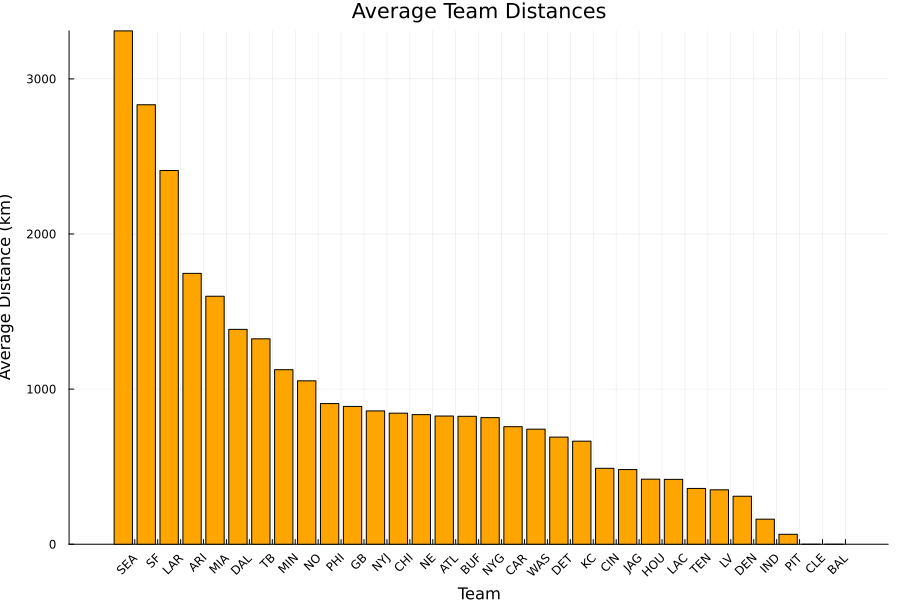

In [27]:
println("\nAnaliza wrażliwości: Limit 2 mecze u siebie, maksymalnie 3 mecze z dywizji")
sensitivity_analysis(2, 3)


Analiza wrażliwości: Limit 1 mecz u siebie z rzędu, maksymalnie 2 mecze dywizji z rzędu

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 1
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  MIA vs CLE in Home, Distance: 1734.07 km
  NE vs JAG in Home, Distance: 1602.92 km
  LAR vs PIT in Home, Distance: 3435.03 km
  SF vs CAR in Home, Distance: 3662.88 km
  PHI vs HOU in Home, Distance: 2162.56 km
  NYG vs IND in Home, Distance: 1031.03 km
  ARI vs NYJ in Home, Distance: 3450.12 km
  NO vs DET in Home, Distance: 1513.23 km
  MIN vs CHI in Home, Distance: 571.87 km
  TB vs CIN in Home, Distance: 1250.32 km
  SEA vs BUF in Home, Distance: 3408.67 km
  GB vs TEN in Home, Distance: 933.19 km
  DEN vs BAL in Home, Distance: 2426.43 km
  ATL vs DAL in Sao Paulo, Distance: 7520.84 km
  LAC vs LV in Home, Distance: 364.5 km
  WAS vs KC in Home, Distance: 1520.73 km
Week 2:
  CLE vs DET in Home, Distance: 144.91 km
  MIA vs HOU in Home, Distance: 1547.98 km
  TEN vs J

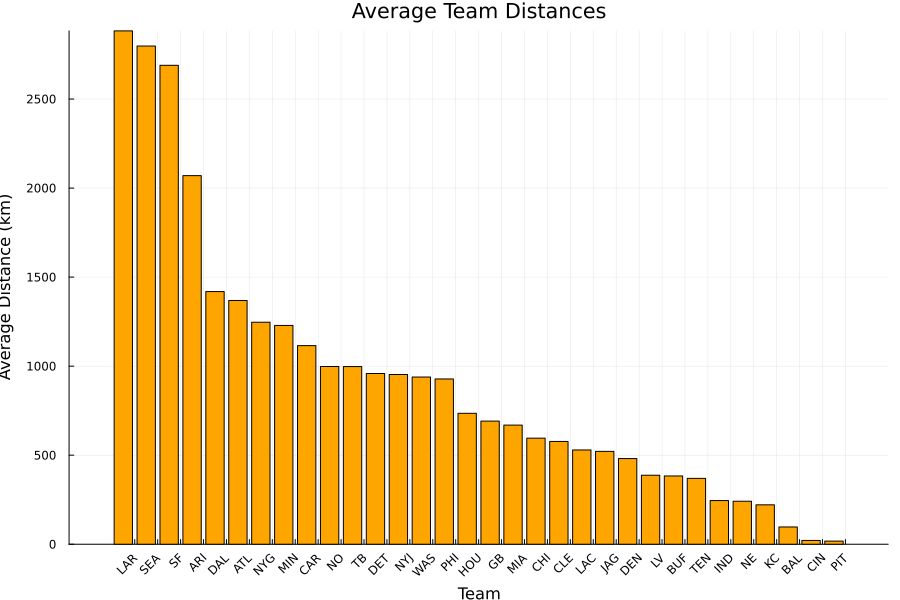

In [28]:
println("\nAnaliza wrażliwości: Limit 1 mecz u siebie z rzędu, maksymalnie 2 mecze dywizji z rzędu")
sensitivity_analysis(1, 2)


--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 3
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  DET vs DEN in Home, Distance: 1860.04 km
  HOU vs JAG in Home, Distance: 1328.26 km
  PIT vs CLE in Home, Distance: 183.99 km
  MIA vs LV in Home, Distance: 3493.8 km
  LAR vs SF in Home, Distance: 502.51 km
  BAL vs LAC in Sao Paulo, Distance: 7650.03 km
  DAL vs NE in Home, Distance: 2493.63 km
  PHI vs TEN in Home, Distance: 1096.76 km
  NYG vs CIN in Home, Distance: 909.43 km
  ARI vs ATL in Home, Distance: 2571.41 km
  MIN vs BUF in Home, Distance: 1183.75 km
  TB vs GB in Home, Distance: 1902.77 km
  SEA vs CAR in Home, Distance: 3669.94 km
  CHI vs KC in Home, Distance: 659.6 km
  WAS vs NO in Home, Distance: 1565.22 km
  NYJ vs IND in Home, Distance: 1031.03 km
Week 2:
  BUF vs PIT in Home, Distance: 278.2 km
  MIA vs CIN in Home, Distance: 1514.33 km
  NE vs IND in Home, Distance: 1276.56 km
  LAR vs MIN in Home, Distance: 2454.59 km
  SF vs BAL in Ho

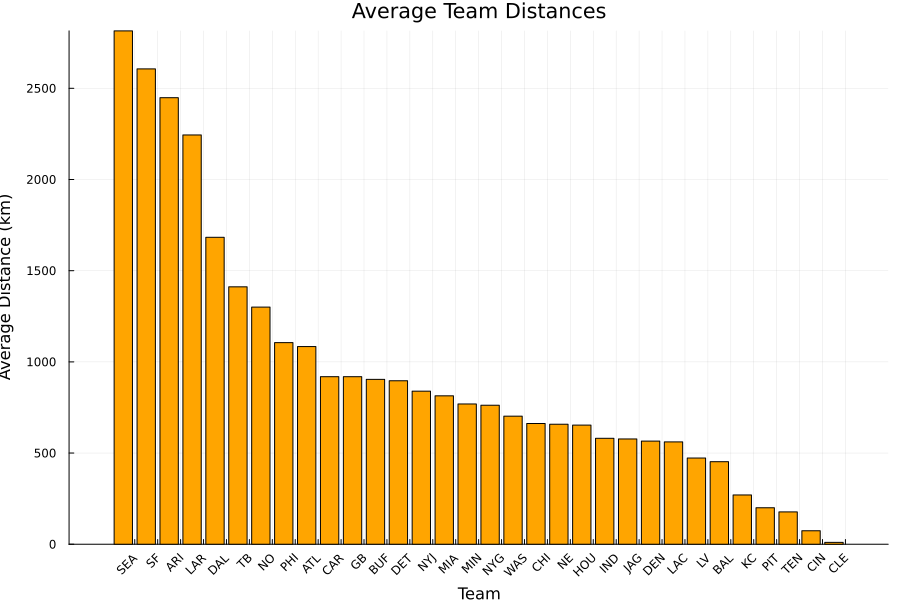

In [29]:
sensitivity_analysis(3, 2) 

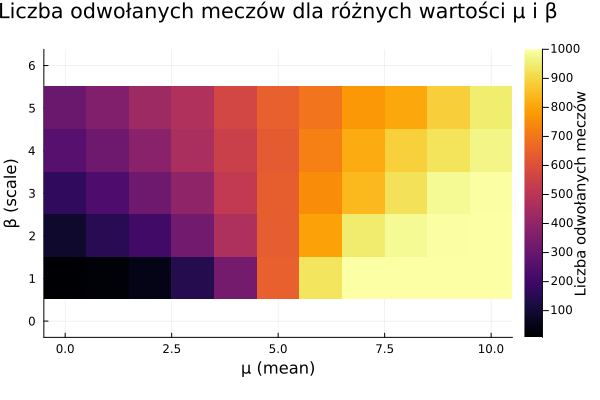

In [30]:
using Distributions
using Plots

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)  
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end


function simulate_schedule(international_assignments, μ, β, threshold)
    canceled_matches = 0
    for _ in 1:international_assignments
        if should_cancel_game_gumbel(μ, β, threshold)
            canceled_matches += 1
        end
    end
    return canceled_matches
end


international_assignments = 1000  
threshold = 5.0  


μ_values = 0:1:10  
β_values = 1:1:5  


results = zeros(Float64, length(μ_values), length(β_values))

for i in 1:length(μ_values)
    for j in 1:length(β_values)
        μ = μ_values[i]
        β = β_values[j]
        results[i, j] = simulate_schedule(international_assignments, μ, β, threshold)
    end
end

heatmap(μ_values, β_values, results',
    xlabel = "μ (mean)",
    ylabel = "β (scale)",
    title = "Liczba odwołanych meczów dla różnych wartości μ i β",
    colorbar_title = "Liczba odwołanych meczów",
    aspect_ratio = :equal
)


In [31]:
using Plots
using DataFrames


function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β) 
    extreme_value = rand(gumbel_dist) 
    return extreme_value > threshold 
end

function simulate_schedule(μ_values, β_values, threshold, num_simulations)
    results = DataFrame(μ = Float64[], β = Float64[], canceled_games = Int[])
    
    for μ in μ_values, β in β_values
        canceled_count = 0
        for _ in 1:num_simulations
            if should_cancel_game_gumbel(μ, β, threshold)
                canceled_count += 1
            end
        end
        push!(results, (μ, β, canceled_count))
    end
    
    return results
end


μ_values = 1.0:1.0:4.0  
β_values = 0.5:0.5:2.0  
threshold = 2.5        
num_simulations = 1000  

results = simulate_schedule(μ_values, β_values, threshold, num_simulations)

heatmap(
    μ_values, β_values, 
    [results[(results.μ .== μ) .& (results.β .== β), :canceled_games][1] for μ in μ_values, β in β_values],
    xlabel = "μ (Mean)", ylabel = "β (Scale)", title = "Wpływ parametrów rozkładu Gumbela na liczbę odwołanych meczów",
    color = :viridis, colorbar_title = "Canceled Games"
)

println("\nTabela wyników:")
display(results)



Tabela wyników:


Row,μ,β,canceled_games
,Float64,Float64,Int64
1,1.0,0.5,54
2,1.0,1.0,213
3,1.0,1.5,284
4,1.0,2.0,380
5,2.0,0.5,280
6,2.0,1.0,442
7,2.0,1.5,520
8,2.0,2.0,536
9,3.0,0.5,928
